<a href="https://colab.research.google.com/github/Akshayc10/Data-Science-Portfolio/blob/master/Stock_Market_Prediction_using_Auto_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the libraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 8.7MB 17.7MB/s 
     |████████████████████████████████| 2.1MB 16.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20


In [ ]:
import pandas_datareader as web

In [ ]:
 
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2015-07-08', end='2020-07-02') 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-08,124.639999,122.540001,124.480003,122.570000,60761600.0,112.961594
2015-07-09,124.059998,119.220001,123.849998,120.070000,78595000.0,110.657570
2015-07-10,123.849998,121.209999,121.940002,123.279999,61354500.0,113.615921
2015-07-13,125.760002,124.320000,125.029999,125.660004,41440500.0,115.809349
2015-07-14,126.370003,125.040001,126.040001,125.610001,31768100.0,115.763260
...,...,...,...,...,...,...
2020-06-26,365.320007,353.019989,364.410004,353.630005,51314200.0,353.630005
2020-06-29,362.170013,351.279999,353.250000,361.779999,32661500.0,361.779999
2020-06-30,365.980011,360.000000,360.079987,364.799988,35055800.0,364.799988


In [ ]:
df.shape

(1257, 6)

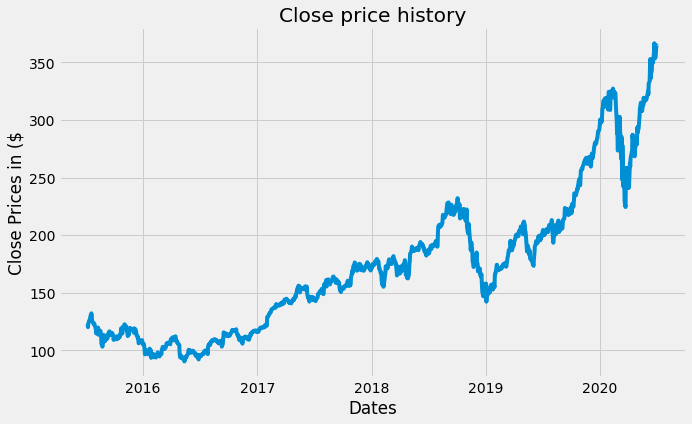

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices in ($')
plt.plot(df['Close'])
plt.title('Close price history')
plt.show()


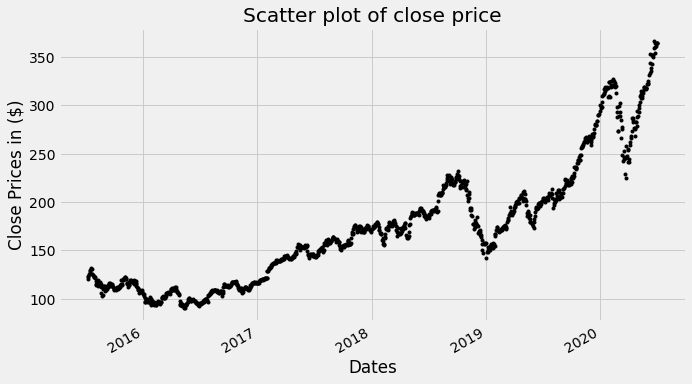

In [ ]:
df_close = df['Close']
df_close.plot(style='k.')
plt.xlabel('Dates')
plt.ylabel('Close Prices in ($)')
plt.title('Scatter plot of close price')
plt.show()

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.
First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

 let's check for stationarity:

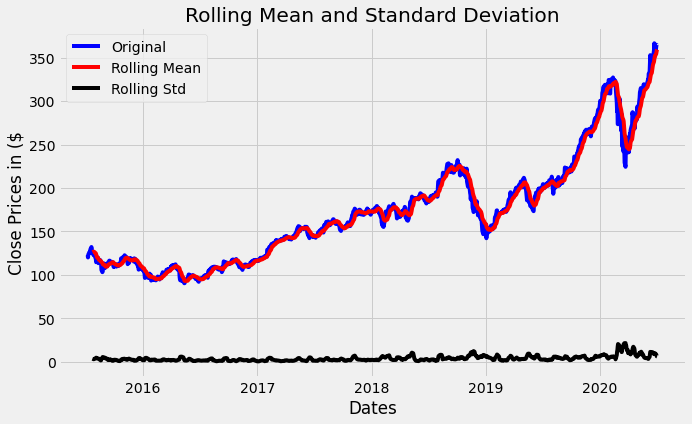

Results of dickey fuller test
Test Statistics                   0.750918
p-value                           0.990801
No. of lags used                 14.000000
Number of observations used    1242.000000
critical value (1%)              -3.435626
critical value (5%)              -2.863870
critical value (10%)             -2.568010
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Dates')
    plt.ylabel('Close Prices in ($')

    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

In [ ]:
# Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

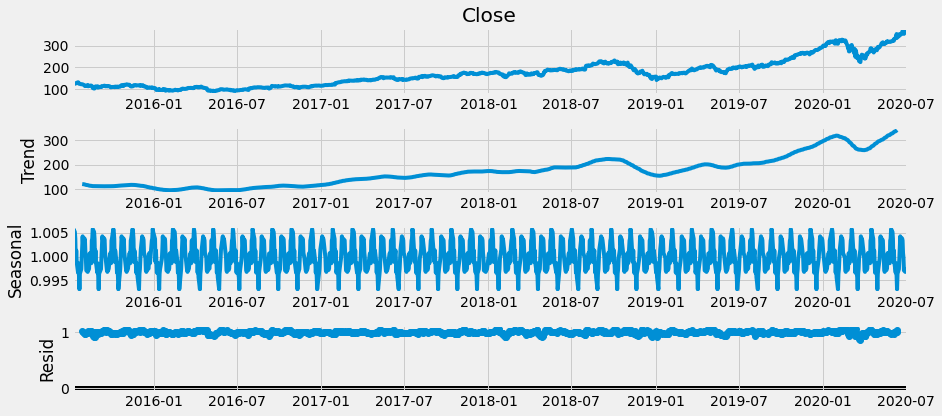

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 6)

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


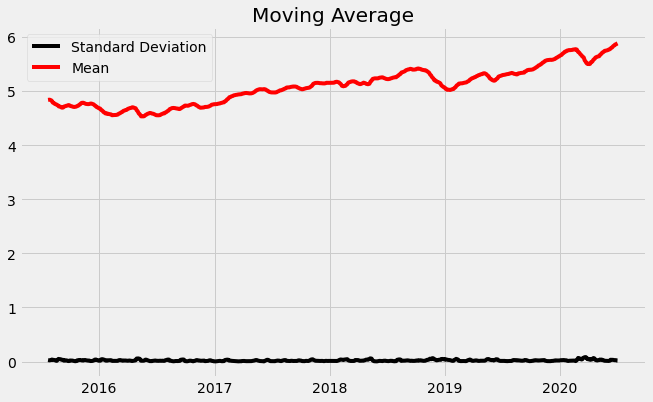

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

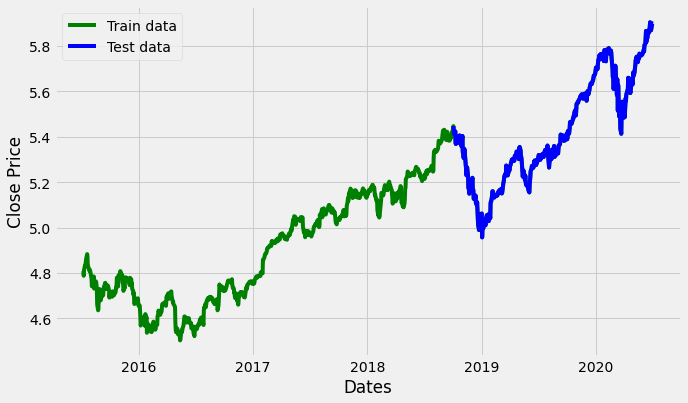

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.65)], df_log[int(len(df_log)*0.65):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.
The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-4585.379, BIC=-4575.977, Time=0.122 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-4585.519, BIC=-4571.417, Time=0.114 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-4585.545, BIC=-4571.443, Time=0.159 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-4585.232, BIC=-4580.532, Time=0.072 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-4583.552, BIC=-4564.749, Time=0.942 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-4583.558, BIC=-4564.755, Time=0.332 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-4581.666, BIC=-4558.163, Time=1.356 seconds
Total fit time: 3.108 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  814
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2295.773
Date:                Mon, 13 Ju

 let’s review the residual plots from auto ARIMA

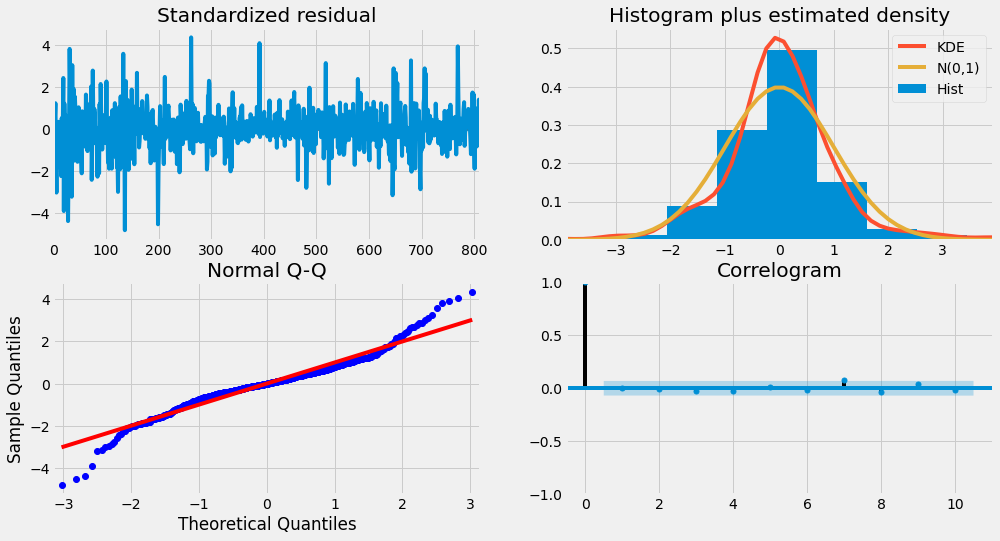

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  814
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2295.773
Date:                Tue, 07 Jul 2020   AIC                          -4585.545
Time:                        17:23:02   BIC                          -4571.443
Sample:                             0   HQIC                         -4580.132
                                - 814                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      1.385      0.166      -0.000       0.002
ma.L1          0.0510      0.028      1.799      0.072      -0.005       0.107
sigma2         0.0002   6.23e-06     33.088      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       27.61   Jarque-Bera (JB):               388.75
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

create an ARIMA model with provided optimal parameters p, d and q.

In [ ]:
model = ARIMA(train_data, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  813
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2295.773
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 13 Jul 2020   AIC                          -4585.546
Time:                        18:28:12   BIC                          -4571.444
Sample:                             1   HQIC                         -4580.133
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.396      0.163      -0.000       0.002
ma.L1.D.Close     0.0518      0.035      1.477      0.140      -0.017       0.121
                                    Root

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

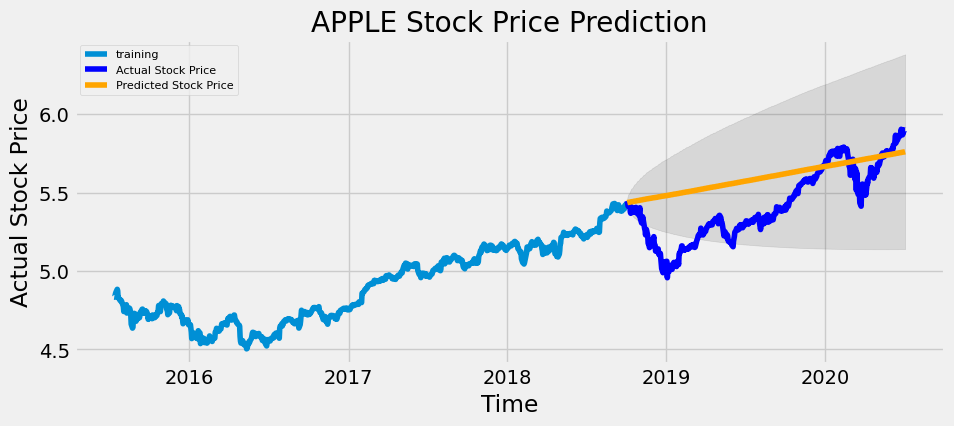

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(440, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(10,4), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Let us also check the commonly used accuracy metrics to judge forecast results:

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.054673724401020043
MAE: 0.19609078206900624
RMSE: 0.23382413134879823
MAPE: 0.03709734171367935
